# BirdCLEF 2023 - EDA
The goal here is to apply the guidelines and approach presented in the [First Steps, Road to the Top](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) series of notebooks. Following that series, we'll look to use FastAI/PyTorch to create an effective validation set and iterate rapidly!

To overall plan is to start with transfer learning to train CNNs on spectrograms.

This notebook focuses on exploratory data analysis. The analysis guides conversion of audio to spectrograms and identifies avenues to explore to improve performance later.

# Setup

## Download competition data and install packages
Prerequisites if running off of Kaggle:
1. Create a python environment
2. [Create `~/.kaggle/kaggle.json`](https://www.kaggle.com/docs/api)
3. [Join the competition](https://www.kaggle.com/competitions/birdclef-2023)

In [1]:
from fastkaggle import setup_comp

comp  = 'birdclef-2023'
comp_path = setup_comp(comp, install='fastai timm fastaudio')
comp_path.ls()

(#6) [Path('birdclef-2023/eBird_Taxonomy_v2021.csv'),Path('birdclef-2023/test_soundscapes'),Path('birdclef-2023/train_metadata.csv'),Path('birdclef-2023/train_audio'),Path('birdclef-2023/sample_submission.csv'),Path('birdclef-2023/train_audio_prep')]

## Load packages

In [2]:
from fastai.vision.all import *
import pandas as pd
import itertools
import torch
import torchaudio
import IPython.display
import mimetypes
from tqdm.auto import tqdm

from sklearn.model_selection import StratifiedKFold
from fastaudio.core.all import *
from fastaudio.augment.all import *

print(torch.__version__, torchaudio.__version__)

1.13.1 0.13.1


# EDA

In [3]:
trn_path = comp_path/'train_audio'
trn_path.ls()

(#264) [Path('birdclef-2023/train_audio/somgre1'),Path('birdclef-2023/train_audio/whcpri2'),Path('birdclef-2023/train_audio/egygoo'),Path('birdclef-2023/train_audio/woosan'),Path('birdclef-2023/train_audio/yebapa1'),Path('birdclef-2023/train_audio/hamerk1'),Path('birdclef-2023/train_audio/hartur1'),Path('birdclef-2023/train_audio/rebfir2'),Path('birdclef-2023/train_audio/strher'),Path('birdclef-2023/train_audio/wtbeat1')...]

## Confirm data
Expect 16941 `.ogg` files and no other training files

In [4]:
ogg_files = get_files(trn_path, extensions='.ogg')
assert len(ogg_files) == 16941, 'Do not have expected number of training ogg files'
ogg_files

(#16941) [Path('birdclef-2023/train_audio/somgre1/XC446893.ogg'),Path('birdclef-2023/train_audio/somgre1/XC633806.ogg'),Path('birdclef-2023/train_audio/somgre1/XC655042.ogg'),Path('birdclef-2023/train_audio/somgre1/XC412153.ogg'),Path('birdclef-2023/train_audio/somgre1/XC411731.ogg'),Path('birdclef-2023/train_audio/somgre1/XC459432.ogg'),Path('birdclef-2023/train_audio/somgre1/XC728971.ogg'),Path('birdclef-2023/train_audio/somgre1/XC600782.ogg'),Path('birdclef-2023/train_audio/somgre1/XC607223.ogg'),Path('birdclef-2023/train_audio/somgre1/XC718280.ogg')...]

In [5]:
num_other_files = len(get_files(trn_path)) - len(ogg_files)
assert num_other_files == 0, 'Found non-ogg training files!'

In [6]:
IPython.display.Audio(filename=ogg_files[0])

## Load Sample Submission

In [7]:
sample_sub_df = pd.read_csv(comp_path/'sample_submission.csv')
sample_sub_df.head()

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,soundscape_29201_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,soundscape_29201_15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Load & Explore Provided Metadata

In [8]:
trn_df = pd.read_csv(comp_path/'train_metadata.csv')
lst_cols = ['secondary_labels', 'type']
for col in lst_cols:
    trn_df[col] = trn_df[col].apply(lambda x: x[1:-1].split(','))
    
assert len(trn_df) == len(ogg_files), 'Number of ogg files does not match number of rows in the training metadata'
trn_df.head().T

,0,1,2,3,4
primary_label,abethr1,abethr1,abethr1,abethr1,abethr1
secondary_labels,[],[],[],[],[]
type,['song'],['call'],['song'],['song'],"['call', 'song']"
latitude,4.3906,-2.9524,-2.9524,-2.9524,-2.9524
longitude,38.2788,38.2921,38.2921,38.2921,38.2921
scientific_name,Turdus tephronotus,Turdus tephronotus,Turdus tephronotus,Turdus tephronotus,Turdus tephronotus
common_name,African Bare-eyed Thrush,African Bare-eyed Thrush,African Bare-eyed Thrush,African Bare-eyed Thrush,African Bare-eyed Thrush
author,Rolf A. de By,James Bradley,James Bradley,James Bradley,James Bradley
license,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0
rating,4.0,3.5,3.5,5.0,4.5


### Primary Label

There should be 264 primary labels.

In [9]:
assert len(trn_df.primary_label.unique()) == 264, 'Did not find the expected number of primary labels'

In [10]:
L(list(trn_df.primary_label.unique()))

(#264) ['abethr1','abhori1','abythr1','afbfly1','afdfly1','afecuc1','affeag1','afgfly1','afghor1','afmdov1'...]

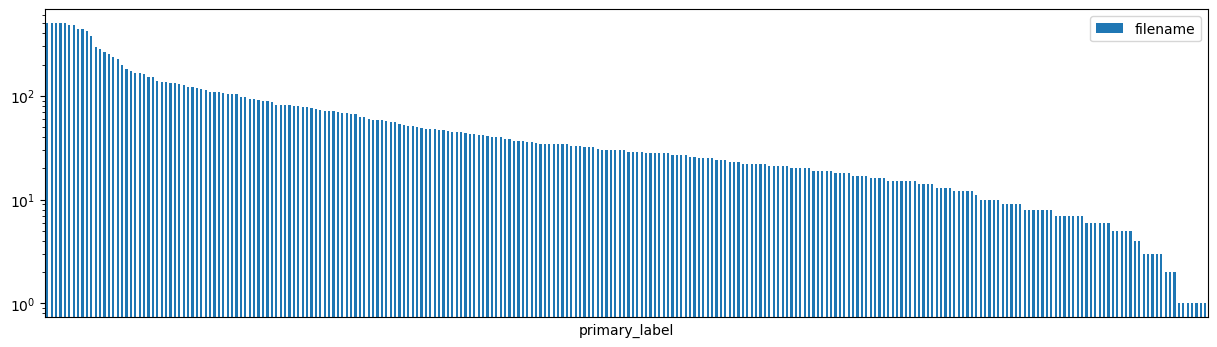

In [11]:
_ = trn_df.pivot_table(index='primary_label', values='filename', aggfunc='count', dropna=False).sort_values('filename', ascending=False).plot.bar(logy=True, xticks=[], figsize=(15,4))

Many species have 10 or fewer labels!

### Secondary Labels

There are more secondary labels than primary labels. That should mean there are sounds of birds we do not need to predict.

In [12]:
len(set(itertools.chain.from_iterable(trn_df.secondary_labels)))

316

In [13]:
trn_df.secondary_labels.value_counts(dropna=False)

[]                                                 14636
['combul2']                                          169
['somgre1']                                           76
['rindov']                                            74
['wlwwar']                                            64
                                                   ...  
['klacuc1',  'laudov1']                                1
['carcha1',  'hadibi1',  'helgui']                     1
['grbcam1',  'gyhspa1',  'laudov1']                    1
['carcha1',  'reftin1']                                1
['grbcam1',  'gryapa1',  'ndcsun2',  'yertin1']        1
Name: secondary_labels, Length: 751, dtype: int64

If we were to start by looking only at clips without secondary labels, what would our coverage of the species be?

In [14]:
len(trn_df.secondary_labels)

16941

In [15]:
trn_df.secondary_labels[0]

['']

In [16]:
temp_df = trn_df[trn_df.secondary_labels.apply(lambda x: x[0] == '')]
len(temp_df)

14636

In [17]:
len(temp_df.primary_label.unique())

263

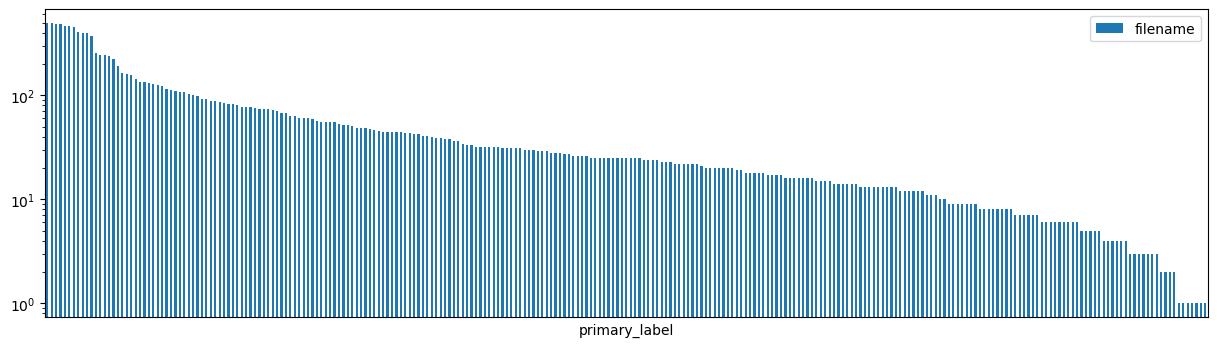

In [18]:
_ = temp_df.pivot_table(index='primary_label', values='filename', aggfunc='count', dropna=False).sort_values('filename', ascending=False).plot.bar(logy=True, xticks=[], figsize=(15,4))

### Type
There is a lot here. We will ignore it for now, but should try to use this information later on.

In [19]:
len(set(itertools.chain.from_iterable(trn_df.type)))

448

In [20]:
trn_df.type.value_counts(dropna=False)

['song']                                                          4102
['call']                                                          3987
['']                                                              1776
['flight call']                                                   1139
['call',  'song']                                                  527
                                                                  ... 
['aggressive calls',  'call']                                        1
['adult',  'duet',  'song']                                          1
['adult',  'call',  'nocturnal flight call',  'sex uncertain']       1
['dawn song',  'life stage uncertain',  'male',  'song']             1
['demonstrative tapping',  'male']                                   1
Name: type, Length: 796, dtype: int64

### Rating

May want to filter or weight training data using the ratings

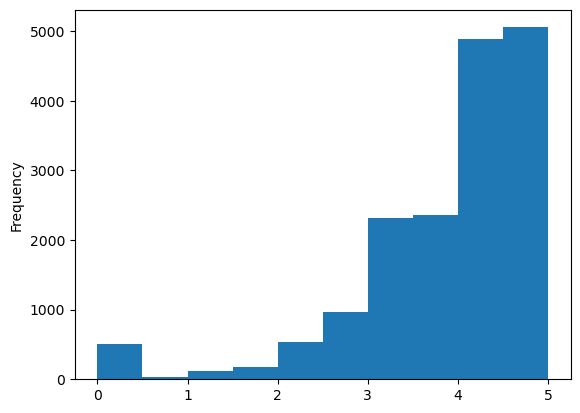

In [21]:
_ = trn_df.rating.plot.hist()

## Extract Audio Metadata

Mostly for learning, but also to look at the distribution of audio file lengths. We're told the sample rates are consistent, but it is worth knowning how to check for future projects.

Bits per sample is zero. I assume this is because the audio has been encoded with a variable bitrate. 

In [25]:
md = torchaudio.info(trn_path/trn_df.filename[0])
print(md)

AudioMetaData(sample_rate=32000, num_frames=1459513, num_channels=1, bits_per_sample=0, encoding=VORBIS)


In [26]:
audio_metadata_df = get_audio_files_metadata(trn_df.filename, parent=trn_path)
audio_metadata_df.to_csv('audio_metadata.csv')

Extracting audio metadata:   0%|          | 0/16941 [00:00<?, ?it/s]

In [27]:
audio_metadata_df

,sample_rate,num_frames,num_channels,bits_per_sample,encoding,seconds
filename,,,,,,
abethr1/XC128013.ogg,32000,1459513,1,0,VORBIS,45.609781
abethr1/XC363501.ogg,32000,597682,1,0,VORBIS,18.677563
abethr1/XC363502.ogg,32000,1240503,1,0,VORBIS,38.765719
abethr1/XC363503.ogg,32000,936229,1,0,VORBIS,29.257156
abethr1/XC363504.ogg,32000,1355024,1,0,VORBIS,42.344500
...,...,...,...,...,...,...
yewgre1/XC703472.ogg,32000,669571,1,0,VORBIS,20.924094
yewgre1/XC703485.ogg,32000,694648,1,0,VORBIS,21.707750
yewgre1/XC704433.ogg,32000,2588003,1,0,VORBIS,80.875094


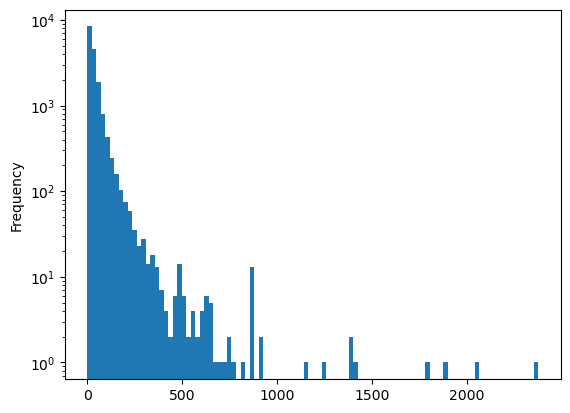

In [28]:
_ = audio_metadata_df.seconds.plot.hist(logy=True, bins=100)

In [29]:
audio_metadata_df.describe()

,sample_rate,num_frames,num_channels,bits_per_sample,seconds
count,16941.0,1.694100e+04,16941.0,16941.0,16941.000000
mean,32000.0,1.308338e+06,1.0,0.0,40.885565
std,0.0,2.227529e+06,0.0,0.0,69.610286
min,32000.0,1.753600e+04,1.0,0.0,0.548000
25%,32000.0,4.087640e+05,1.0,0.0,12.773875
50%,32000.0,7.879680e+05,1.0,0.0,24.624000
75%,32000.0,1.467873e+06,1.0,0.0,45.871031
max,32000.0,7.595290e+07,1.0,0.0,2373.528000


In [30]:
audio_metadata_df.encoding.unique()

array(['VORBIS'], dtype=object)

# Audio Preprocess Experimentation

In [31]:
prep_path = comp_path/'train_audio_prep'
prep_path.mkdir(exist_ok=True)

## Test Case

In [32]:
cfg = AudioConfig.BasicSpectrogram()
aud2spec = AudioToSpec.from_cfg(cfg)
cfg

BasicSpectrogram(n_fft=400, win_length=None, hop_length=None, pad=0, window_fn=<built-in method hann_window of type object at 0x7f8cfd367140>, power=2.0, normalized=False, wkwargs=None, center=True, pad_mode='reflect', onesided=True, return_complex=None, mel=False, to_db=True)

### Original

birdclef-2023/train_audio/somgre1/XC446893.ogg


<Axes: >

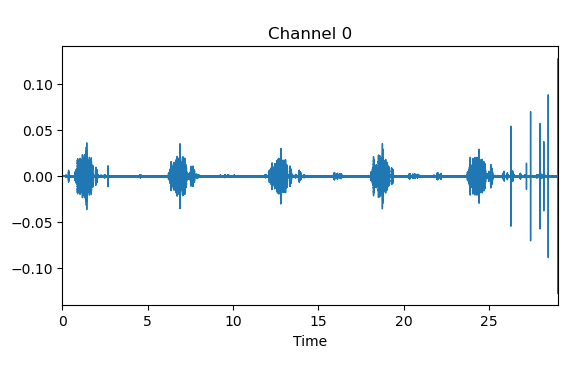

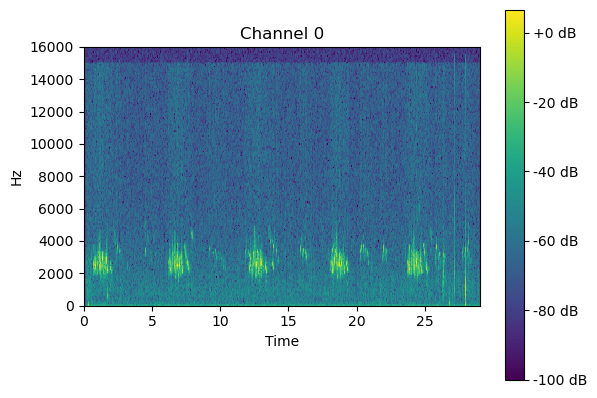

In [33]:
print(ogg_files[0])
pipe = Pipeline([aud2spec])
audio = AudioTensor.create(ogg_files[0])
audio.show()
pipe(audio).show()

### Preprocessed

In [34]:
rmsilence = RemoveSilence(remove_type=RemoveType.All, threshold=30)
resample = Resample(sr_new=16000)
resize = ResizeSignal(duration=10e3)
pipe_prep_1 = Pipeline([resample, rmsilence, resize])
pipe_prep_2 = Pipeline([resample, rmsilence, resize, aud2spec])

<Axes: >

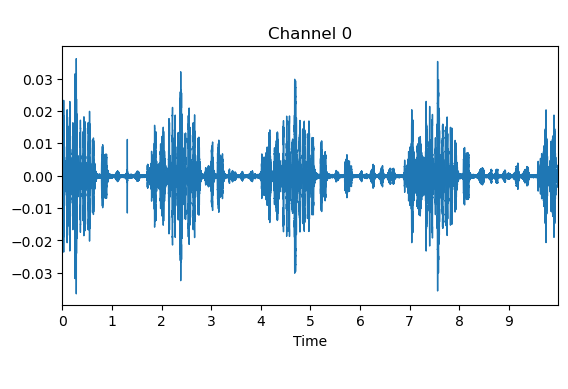

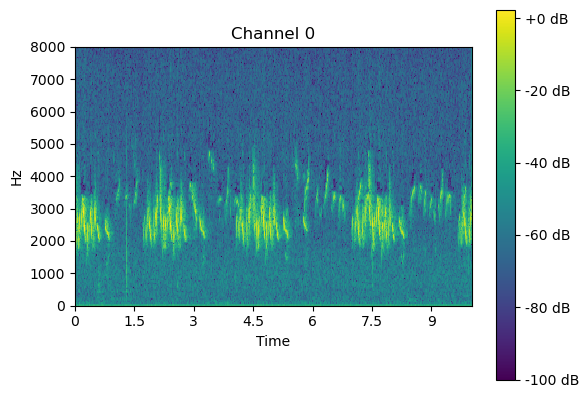

In [35]:
audio_prep = AudioTensor.create(ogg_files[0])
pipe_prep_1(audio_prep).show()
pipe_prep_2(audio_prep).show()

# References

* [fastaudio]: Coultas Blum, Harry A, Lucas G. Scart, and Robert Bracco. 2020. “Fastaudio.” *GitHub*. <https://github.com/fastaudio/fastaudio>.

* [torchaudio]: TorchAudio. <https://pytorch.org/audio/stable/feature_classifications.html>

# Further Exploration

* Use more of fastkaggle https://fastai.github.io/fastkaggle/
* FastAudio: https://colab.research.google.com/github/fastaudio/fastaudio/blob/master/docs/ESC50:%20Environmental%20Sound%20Classification.ipynb#scrollTo=6T8g4m4h3hNq

* One challenge with the dataset here is we have training audio of varying length with lots of quiet periods between bird calls. When we divide up a training audio signal, some pieces will not have bird calls and we don't want to assign the label(s) of the entire file to each piece. We could try multiple instance learning to deal with this. 

* Training audio with multiple labels may further complicate training. Can we start with multiple instance learning using only the training sets with single labels and then use that model to divide our multiple instances into groups with different labels for further training?

* Try TorchAudio pre-trained models as a backbone

* One-hot-encode extras? https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list